### Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

We need to analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, identify the main indicators of churn and recommend strategies to manage customer churn based on your observations.

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

from fancyimpute import KNN

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# importing the data
telecom = pd.read_csv('telecom_churn_data.csv')
telecom.shape

(99999, 226)

In [4]:
# checking the info to get data types and non null counts
telecom.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
mobile_number               99999 non-null int64
circle_id                   99999 non-null int64
loc_og_t2o_mou              98981 non-null float64
std_og_t2o_mou              98981 non-null float64
loc_ic_t2o_mou              98981 non-null float64
last_date_of_month_6        99999 non-null object
last_date_of_month_7        99398 non-null object
last_date_of_month_8        98899 non-null object
last_date_of_month_9        98340 non-null object
arpu_6                      99999 non-null float64
arpu_7                      99999 non-null float64
arpu_8                      99999 non-null float64
arpu_9                      99999 non-null float64
onnet_mou_6                 96062 non-null float64
onnet_mou_7                 96140 non-null float64
onnet_mou_8                 94621 non-null float64
onnet_mou_9                 92254 non-null float64
offnet_mou_6                960

In [5]:
# check null value percentage
round(100*(telecom.isnull().sum()/len(telecom)),2)

mobile_number                0.00
circle_id                    0.00
loc_og_t2o_mou               1.02
std_og_t2o_mou               1.02
loc_ic_t2o_mou               1.02
last_date_of_month_6         0.00
last_date_of_month_7         0.60
last_date_of_month_8         1.10
last_date_of_month_9         1.66
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
arpu_9                       0.00
onnet_mou_6                  3.94
onnet_mou_7                  3.86
onnet_mou_8                  5.38
onnet_mou_9                  7.75
offnet_mou_6                 3.94
offnet_mou_7                 3.86
offnet_mou_8                 5.38
offnet_mou_9                 7.75
roam_ic_mou_6                3.94
roam_ic_mou_7                3.86
roam_ic_mou_8                5.38
roam_ic_mou_9                7.75
roam_og_mou_6                3.94
roam_og_mou_7                3.86
roam_og_mou_8                5.38
roam_og_mou_9                7.75
loc_og_t2t_mou

In [6]:
# check unique values across variables
telecom.apply(pd.Series.nunique)

mobile_number               99999
circle_id                       1
loc_og_t2o_mou                  1
std_og_t2o_mou                  1
loc_ic_t2o_mou                  1
last_date_of_month_6            1
last_date_of_month_7            1
last_date_of_month_8            1
last_date_of_month_9            1
arpu_6                      85681
arpu_7                      85308
arpu_8                      83615
arpu_9                      79937
onnet_mou_6                 24313
onnet_mou_7                 24336
onnet_mou_8                 24089
onnet_mou_9                 23565
offnet_mou_6                31140
offnet_mou_7                31023
offnet_mou_8                30908
offnet_mou_9                30077
roam_ic_mou_6                6512
roam_ic_mou_7                5230
roam_ic_mou_8                5315
roam_ic_mou_9                4827
roam_og_mou_6                8038
roam_og_mou_7                6639
roam_og_mou_8                6504
roam_og_mou_9                5882
loc_og_t2t_mou

In [7]:
# describing numberic variables and checking variance among them
telecom.describe(include='all')

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999,99398,98899,98340,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000

### Data Preparation

In [8]:
# calculating average recharge amount of good pase i.e. 6, 7 month

telecom_df = telecom.copy()

telecom_df['avg_rech_amt_good_phase'] = (telecom_df['total_rech_amt_6'] + telecom_df['total_rech_amt_7'])/2

In [9]:
# extracting 70th quantile value
quant_70 = telecom_df['avg_rech_amt_good_phase'].quantile(0.70)
print(quant_70)

368.5


Filtering High Value Customers : Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [10]:
# keeping only 70th quantile data
telecom_df = telecom_df[telecom_df['avg_rech_amt_good_phase'] > quant_70 ]

# Calculating total usage in Month 9 into variable total_usage_9 
telecom_df['total_usage_9'] = telecom_df['total_og_mou_9'] + telecom_df['total_ic_mou_9'] + telecom_df['vol_2g_mb_9'] + telecom_df['vol_3g_mb_9']

# creating churn variable
telecom_df['churn'] = np.where(telecom_df['total_usage_9']> 0, 0, 1)
telecom_df['churn'].value_counts()

0    27390
1     2589
Name: churn, dtype: int64

In [11]:
# getting percentage of churn & non-churn customers
telecom_df['churn'].value_counts()/len(telecom_df)

0    0.91364
1    0.08636
Name: churn, dtype: float64

In [12]:
# dropping mobile_number, avg_rech_amt_good_phase & total_usage_9
telecom_df = telecom_df.drop(['mobile_number','avg_rech_amt_good_phase','total_usage_9'],1)

As per the analysis scope dropping all the variables of the 9th month after the churn indicator creation

In [13]:
# dropping columns of month 9 or having a sufix "_9"
col_m9 = [col for col in telecom_df.columns if '_9' in col]
telecom_df = telecom_df.drop(col_m9, axis = 1)
print(telecom_df.shape)
telecom_df = telecom_df.drop('sep_vbc_3g', axis=1)

(29979, 172)


In [14]:
# calculating churn-rate
y = telecom_df['churn']
churn = round((sum(y)/len(y.index))*100,2 )
print("Churn-rate is ",churn,"%")
print(telecom_df.shape)


Churn-rate is  8.64 %
(29979, 171)


In [15]:
# checking unique values in each column
telecom_df.nunique().sort_values(ascending=False)

arpu_6                      29230
arpu_7                      29228
arpu_8                      28376
total_og_mou_7              24892
total_og_mou_6              24587
total_og_mou_8              23624
offnet_mou_7                22638
offnet_mou_6                22440
offnet_mou_8                21499
total_ic_mou_7              20696
total_ic_mou_6              20592
total_ic_mou_8              20083
loc_og_mou_7                19866
loc_og_mou_6                19676
loc_ic_mou_6                19122
loc_ic_mou_7                19020
onnet_mou_7                 18933
loc_og_mou_8                18871
onnet_mou_6                 18805
loc_ic_mou_8                18563
std_og_mou_7                18433
std_og_mou_6                18315
onnet_mou_8                 17597
loc_og_t2m_mou_7            16864
std_og_mou_8                16858
loc_og_t2m_mou_6            16738
loc_og_t2m_mou_8            16154
loc_ic_t2m_mou_7            16062
loc_ic_t2m_mou_6            16010
loc_ic_t2m_mou

In [16]:
# removing columns which have only 1 unique value 
telecom_df = telecom_df.loc[:,telecom_df.nunique()>1]
telecom_df.shape

(29979, 158)

In [17]:
# removing date columns
date_cols = [col for col in telecom_df.columns if 'date' in col]
telecom_df = telecom_df.drop(date_cols, axis = 1)
telecom_df.shape

(29979, 152)

In [18]:
# check null value percentage
100*(telecom_df.isnull().sum()/len(telecom_df.index))

arpu_6                 0.000000
arpu_7                 0.000000
arpu_8                 0.000000
onnet_mou_6            1.054071
onnet_mou_7            1.010707
onnet_mou_8            3.128857
offnet_mou_6           1.054071
offnet_mou_7           1.010707
offnet_mou_8           3.128857
roam_ic_mou_6          1.054071
roam_ic_mou_7          1.010707
roam_ic_mou_8          3.128857
roam_og_mou_6          1.054071
roam_og_mou_7          1.010707
roam_og_mou_8          3.128857
loc_og_t2t_mou_6       1.054071
loc_og_t2t_mou_7       1.010707
loc_og_t2t_mou_8       3.128857
loc_og_t2m_mou_6       1.054071
loc_og_t2m_mou_7       1.010707
loc_og_t2m_mou_8       3.128857
loc_og_t2f_mou_6       1.054071
loc_og_t2f_mou_7       1.010707
loc_og_t2f_mou_8       3.128857
loc_og_t2c_mou_6       1.054071
loc_og_t2c_mou_7       1.010707
loc_og_t2c_mou_8       3.128857
loc_og_mou_6           1.054071
loc_og_mou_7           1.010707
loc_og_mou_8           3.128857
std_og_t2t_mou_6       1.054071
std_og_t

In [19]:
# columns with more than 60% missing values
null_val = telecom_df.loc[:,round(100*(telecom_df.isnull().sum()/len(telecom_df.index)),2)>60]
null_val.columns

Index(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7',
       'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
       'fb_user_6', 'fb_user_7', 'fb_user_8'],
      dtype='object')

In [20]:
# droping columns
missing_60pr_cols = ['fb_user','night_pck_user','arpu_2g','arpu_3g','count_rech_3g', 'total_rech_data',
                        'av_rech_amt_data', 'count_rech_2g','max_rech_data']

for col in missing_60pr_cols:
    for month in ['6', '7', '8']:
        missing_60pr_cols = col + '_' + month
        telecom_df = telecom_df.drop([missing_60pr_cols], 1)
        
telecom_df.shape

(29979, 125)

In [21]:
telecom_df = telecom_df.reset_index()

In [22]:
telecom_df = telecom_df.drop('index',1)

In [23]:
telecom_df_backup = telecom_df.copy()

#### Imputing missing observations using KNNImputer

In [24]:
# dropping churn variable for imputing missing values in other features
telecome_scaled = telecom_df.drop("churn", axis = 1)
telecome_scaled.shape

(29979, 124)

In [25]:
%%time
# imputing missing values
telecome_imputed= KNN(k=3).fit_transform(telecome_scaled)

Imputing row 1/29979 with 0 missing, elapsed time: 2749.499
Imputing row 101/29979 with 27 missing, elapsed time: 2757.076
Imputing row 201/29979 with 0 missing, elapsed time: 2759.154
Imputing row 301/29979 with 0 missing, elapsed time: 2759.857
Imputing row 401/29979 with 0 missing, elapsed time: 2760.717
Imputing row 501/29979 with 0 missing, elapsed time: 2761.513
Imputing row 601/29979 with 0 missing, elapsed time: 2761.810
Imputing row 701/29979 with 0 missing, elapsed time: 2762.185
Imputing row 801/29979 with 0 missing, elapsed time: 2762.263
Imputing row 901/29979 with 0 missing, elapsed time: 2763.045
Imputing row 1001/29979 with 0 missing, elapsed time: 2763.045
Imputing row 1101/29979 with 0 missing, elapsed time: 2763.779
Imputing row 1201/29979 with 0 missing, elapsed time: 2764.466
Imputing row 1301/29979 with 0 missing, elapsed time: 2764.623
Imputing row 1401/29979 with 0 missing, elapsed time: 2764.748
Imputing row 1501/29979 with 0 missing, elapsed time: 2765.185
Imp

Imputing row 13001/29979 with 0 missing, elapsed time: 2797.167
Imputing row 13101/29979 with 0 missing, elapsed time: 2797.542
Imputing row 13201/29979 with 0 missing, elapsed time: 2797.933
Imputing row 13301/29979 with 0 missing, elapsed time: 2798.370
Imputing row 13401/29979 with 0 missing, elapsed time: 2798.573
Imputing row 13501/29979 with 0 missing, elapsed time: 2798.573
Imputing row 13601/29979 with 0 missing, elapsed time: 2798.917
Imputing row 13701/29979 with 0 missing, elapsed time: 2799.026
Imputing row 13801/29979 with 0 missing, elapsed time: 2799.136
Imputing row 13901/29979 with 0 missing, elapsed time: 2799.417
Imputing row 14001/29979 with 0 missing, elapsed time: 2799.698
Imputing row 14101/29979 with 0 missing, elapsed time: 2799.886
Imputing row 14201/29979 with 0 missing, elapsed time: 2800.026
Imputing row 14301/29979 with 0 missing, elapsed time: 2800.198
Imputing row 14401/29979 with 0 missing, elapsed time: 2800.511
Imputing row 14501/29979 with 0 missing,

Imputing row 25801/29979 with 0 missing, elapsed time: 2822.259
Imputing row 25901/29979 with 0 missing, elapsed time: 2822.447
Imputing row 26001/29979 with 0 missing, elapsed time: 2822.556
Imputing row 26101/29979 with 0 missing, elapsed time: 2822.634
Imputing row 26201/29979 with 0 missing, elapsed time: 2822.759
Imputing row 26301/29979 with 0 missing, elapsed time: 2822.853
Imputing row 26401/29979 with 0 missing, elapsed time: 2823.150
Imputing row 26501/29979 with 0 missing, elapsed time: 2823.400
Imputing row 26601/29979 with 0 missing, elapsed time: 2823.509
Imputing row 26701/29979 with 0 missing, elapsed time: 2823.619
Imputing row 26801/29979 with 0 missing, elapsed time: 2823.884
Imputing row 26901/29979 with 27 missing, elapsed time: 2824.181
Imputing row 27001/29979 with 0 missing, elapsed time: 2824.431
Imputing row 27101/29979 with 0 missing, elapsed time: 2824.462
Imputing row 27201/29979 with 0 missing, elapsed time: 2824.868
Imputing row 27301/29979 with 0 missing

In [26]:
%%time
# converting imputed dat into dataframe
cols= telecome_scaled.columns
telecome_df1 = pd.DataFrame(telecome_imputed, columns=cols)
telecome_df1.head()

Wall time: 2.33 s
Parser   : 305 ms


,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5.0,5.0,7.0,1580.0,790.0,3638.0,1580.0,790.0,1580.0,0.0,0.0,779.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,802.0,57.74,19.38,18.74
1,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19.0,21.0,14.0,437.0,601.0,120.0,90.0,154.0,30.0,50.0,0.0,10.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,21.03,910.65,122.16
2,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,701.78,138.93,655.18,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,215.58,26.11,255.26,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,423.81,68.09,474.41,968.61,172.58,1144.53,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6.0,4.0,11.0,507.0,253.0,717.0,110.0,110.0,130.0,110.0,50.0,0.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2607.0,0.00,0.00,0.00
3,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.

In [27]:
# adding churn variable back to the dataframe
telecome_df1['churn']=telecom_df['churn']
telecome_df1.shape

(29979, 125)

In [28]:
# cross-check for any missing values
telecome_df1.isnull().sum()

arpu_6                0
arpu_7                0
arpu_8                0
onnet_mou_6           0
onnet_mou_7           0
onnet_mou_8           0
offnet_mou_6          0
offnet_mou_7          0
offnet_mou_8          0
roam_ic_mou_6         0
roam_ic_mou_7         0
roam_ic_mou_8         0
roam_og_mou_6         0
roam_og_mou_7         0
roam_og_mou_8         0
loc_og_t2t_mou_6      0
loc_og_t2t_mou_7      0
loc_og_t2t_mou_8      0
loc_og_t2m_mou_6      0
loc_og_t2m_mou_7      0
loc_og_t2m_mou_8      0
loc_og_t2f_mou_6      0
loc_og_t2f_mou_7      0
loc_og_t2f_mou_8      0
loc_og_t2c_mou_6      0
loc_og_t2c_mou_7      0
loc_og_t2c_mou_8      0
loc_og_mou_6          0
loc_og_mou_7          0
loc_og_mou_8          0
std_og_t2t_mou_6      0
std_og_t2t_mou_7      0
std_og_t2t_mou_8      0
std_og_t2m_mou_6      0
std_og_t2m_mou_7      0
std_og_t2m_mou_8      0
std_og_t2f_mou_6      0
std_og_t2f_mou_7      0
std_og_t2f_mou_8      0
std_og_mou_6          0
std_og_mou_7          0
std_og_mou_8    

In [29]:
telecom_df = telecome_df1.copy()

In [30]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29979 entries, 0 to 29978
Columns: 125 entries, arpu_6 to churn
dtypes: float64(124), int32(1)
memory usage: 28.5 MB


#### Outlier Treatment

In [31]:
telecom_df.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,587.587624,589.424681,535.067748,296.760167,304.964055,268.684210,419.172491,424.901965,376.875150,17.670435,13.699813,13.572490,29.672163,22.260973,21.891852,94.873637,95.947781,87.511545,181.755371,181.730130,168.420516,7.009212,7.118829,6.544541,1.578824,1.872160,1.736961,283.647077,284.805759,262.485144,190.151463,200.187610,172.753628,203.539640,213.725714,180.194159,2.022914,2.046107,1.803171,395.718371,415.963774,354.754895,2.305509,2.221207,2.048192,5.958877,7.464293,6.974239,0.696499,0.047660,0.059303,687.068925,709.531995,624.107691,68.932296,70.552732,66.374487

In [32]:
%%time
# Capping outlier values with 1 and 99 percentile respectively, not to loose any rows while handling outliers
continous_cols = [col for col in telecom_df.columns if col not in ['churn']]

for col in continous_cols:
    percentiles = telecom_df[col].quantile([0.01,0.99]).values
    telecom_df[col][telecom_df[col] <= percentiles[0]] = percentiles[0]
    telecom_df[col][telecom_df[col] >= percentiles[1]] = percentiles[1]

Wall time: 2min 23s


In [33]:
telecom_df.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.0,29979.0,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,578.115790,579.934200,524.618925,288.079296,295.658113,259.412666,411.393056,416.319902,366.927895,15.010112,10.819580,10.912619,25.923442,18.822561,17.994633,86.794501,86.775986,79.031610,176.276580,176.915396,163.953447,6.312448,6.421098,5.939488,1.339372,1.548100,1.497744,276.070451,276.799441,255.344551,182.329605,191.911220,164.576408,195.403134,205.194362,170.386540,1.505053,1.461117,1.290303,386.530963,406.160453,344.038928,0.846403,0.806550,0.573321,5.356105,6.659582,6.106525,0.632230,0.0,0.0,677.591522,698.775000,613.238083,63.036598,64.050736,60.336640,154.795362,155.9086

#### Creating derived variables

Tenure : Created using AON(Age on Network) variable. How many years has the customer been using the network

In [34]:
telecom_df['tenure'] = np.round(telecom_df['aon']/365,1)
bins = [0, 1, 2, 3, 4, 10]
telecom_df['tenure'] = pd.cut(telecom_df['tenure'], bins, labels =[1,2,3,4,10])
#telecom_df['tenure'] = telecom_df['tenure'].astype(int)
telecom_df['tenure'].value_counts()

10    9681
2     7486
1     5320
3     4530
4     2962
Name: tenure, dtype: int64

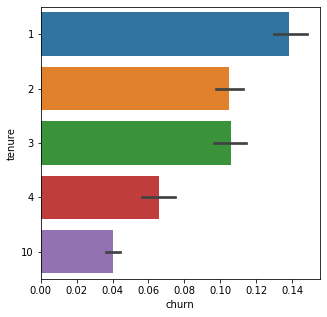

In [35]:
plt.figure(figsize=(5, 5))
sns.barplot(x='churn', y='tenure', data=telecom_df)
plt.show()

Customers with more tenure have less churn rate as compared to customers who are newly acquired to the network.

In [36]:
# dropping base variable for tenure as it will be colinear
telecom_df = telecom_df.drop('aon', 1)

In [37]:
telecom_df.shape

(29979, 125)

In [38]:
# creating variables which will capture the change in corresponding feaures between action phase and average value of good phase
telecom_df['changed_arpu']           = telecom_df['arpu_8'] - ((telecom_df['arpu_6']+telecom_df['arpu_7'])/2)
telecom_df['changed_total_og_mou']   = telecom_df['total_og_mou_8'] - ((telecom_df['total_og_mou_6']+telecom_df['total_og_mou_7'])/2)
telecom_df['changed_total_ic_mou']   = telecom_df['total_ic_mou_8'] - ((telecom_df['total_ic_mou_6']+telecom_df['total_ic_mou_7'])/2)
telecom_df['changed_total_rech_amt'] = telecom_df['total_rech_amt_8'] - ((telecom_df['total_rech_amt_6']+telecom_df['total_rech_amt_7'])/2)
telecom_df['changed_vol_2g_mb']      = telecom_df['vol_2g_mb_8'] - ((telecom_df['vol_2g_mb_6']+telecom_df['vol_2g_mb_7'])/2)
telecom_df['changed_vol_3g_mb']      = telecom_df['vol_3g_mb_8'] - ((telecom_df['vol_3g_mb_6']+telecom_df['vol_3g_mb_7'])/2)
telecom_df['changed_loc_og_mou']     = telecom_df['loc_og_mou_8'] - ((telecom_df['loc_og_mou_6']+telecom_df['loc_og_mou_7'])/2)
telecom_df['changed_loc_ic_mou']     = telecom_df['loc_ic_mou_8'] - ((telecom_df['loc_ic_mou_6']+telecom_df['loc_ic_mou_7'])/2)
telecom_df['changed_std_og_mou']     = telecom_df['std_og_mou_8'] - ((telecom_df['std_og_mou_6']+telecom_df['std_og_mou_7'])/2)
telecom_df['changed_std_ic_mou']     = telecom_df['std_ic_mou_8'] - ((telecom_df['std_ic_mou_6']+telecom_df['std_ic_mou_7'])/2)
telecom_df['changed_spl_ic_mou']     = telecom_df['spl_ic_mou_8'] - ((telecom_df['spl_ic_mou_6']+telecom_df['spl_ic_mou_7'])/2)
telecom_df['changed_spl_og_mou']     = telecom_df['spl_og_mou_8'] - ((telecom_df['spl_og_mou_6']+telecom_df['spl_og_mou_7'])/2)

telecom_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,tenure,changed_arpu,changed_total_og_mou,changed_total_ic_mou,changed_total_rech_amt,changed_vol_2g_mb,changed_vol_3g_mb,changed_loc_og_mou,changed_loc_ic_mou,changed_std_og_mou,changed_std_ic_mou,changed_spl_ic_mou,changed_spl_og_mou
0,1069.180,1349.8500,1988.08226,57.84,54.68,52.29,453.43,567.1600,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.060,14.53,31.5900,15.7400,15.19,15.14,5.0,5.0,7.0,1580.0,790.0,2342.22,1000.0,790.0,951.0,0.0,0.0,619.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.74,19.38,18.74,1,3,778.56726,-198.225,-163.510,1157.22,0.00,0.000,-222.245,-203.515,9.840,17.130,-0.105,4.25
1,378.721,492.2230,137.36200,413.69,351.03,35.08,94.66,80.6300,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.000,0.00,0.0000,0.0000,0.00,0.00,19.0,21.0,14.0,437.0,601.0,120.00,90.0,154.0,30.0,50.0,0.0,10.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,21.03,910.65,122.16,0,1,-298.11000,-298.450,-49.635,-399.00,-177.97,-363.535,-270.095,-36.840,-38.590,-12.795,0.000,10.23
2,492.846,205.6710,593.26000,501.76,108.39,534.24,413.31,119.2800,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,205.31,53.48,353.99,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,701.78,138.93,655.18,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,907.09,192.41,1015.26,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.0

In [39]:
missing_col = ['arpu','total_og_mou','total_ic_mou','total_rech_amt','vol_2g_mb','vol_3g_mb',
               'loc_og_mou', 'loc_ic_mou', 'std_og_mou', 'std_ic_mou', 'spl_ic_mou', 'spl_og_mou' ]

for col in missing_col:
    for month in ['6', '7', '8']:
        missing_col = col + '_' + month
        telecom_df = telecom_df.drop([missing_col], 1)


In [40]:
telecom_df = telecom_df.reset_index()
telecom_df = telecom_df.drop('index',1)

In [41]:
telecom_df.shape

(29979, 101)

### EDA

Text(0.5, 1.0, 'Churn/Non Churn Distribution')

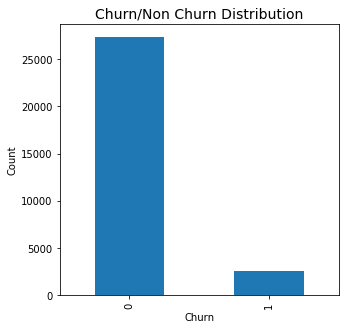

In [42]:
# plotting distribution of churn/non-churn customers
plt.figure(figsize=(5,5))
telecom_df['churn'].value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Churn')
plt.title('Churn/Non Churn Distribution',fontsize=14)

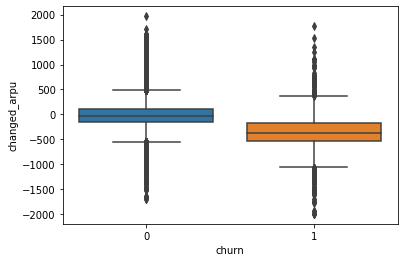

In [43]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_arpu'])

As observed, mean value of change in average revenue generated by churn customers is -ve compared to Non-churn customers

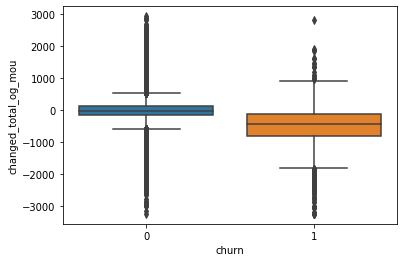

In [44]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_total_og_mou'])

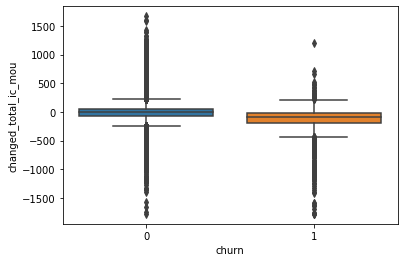

In [45]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_total_ic_mou'])

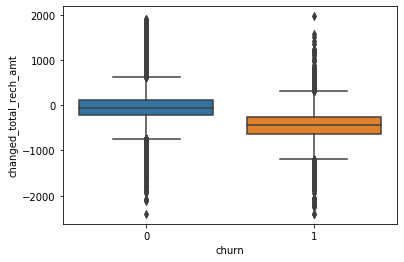

In [46]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_total_rech_amt'])

As observed, mean value of change in Total recharge amount, total outgoing calls, total incoming calls for churn customers is low compared to Non-churn customers

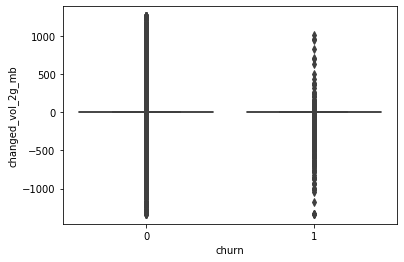

In [47]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_vol_2g_mb'])

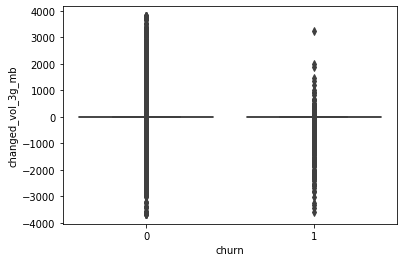

In [48]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_vol_3g_mb'])

There is no change in 2G & 3G volumnes amoung churn & non-churn customers

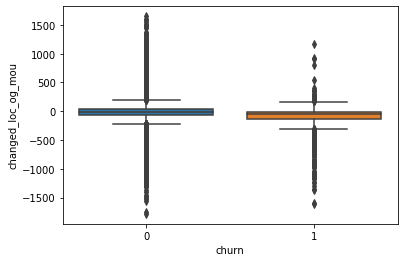

In [49]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_loc_og_mou'])

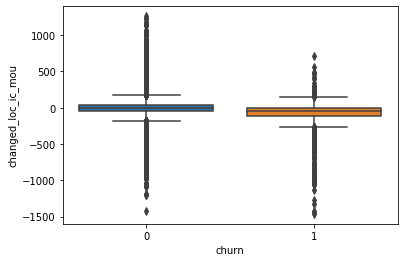

In [50]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_loc_ic_mou'])

As observed, change in average number local incoming and outgoing calls is low for churn customers as compared to non-churn customers

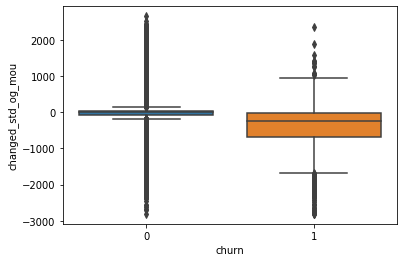

In [51]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_std_og_mou'])

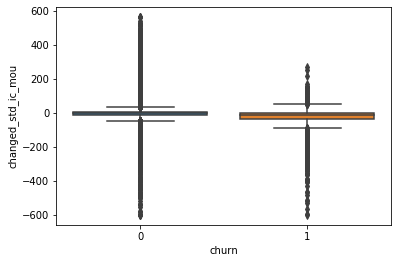

In [52]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_std_ic_mou'])

Change in average incoming & outgoing STD calls are very low for churn customers

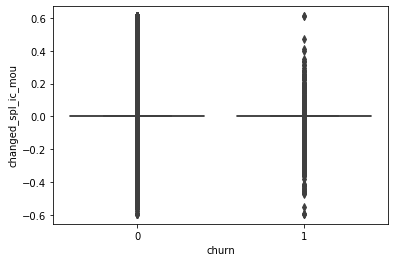

In [53]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_spl_ic_mou'])

No change in Incoming Special calls among churn & non-churn customers

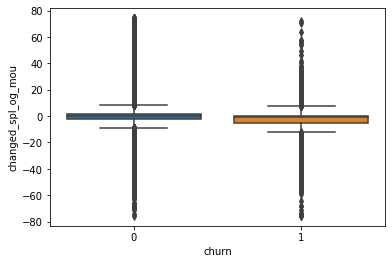

In [54]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_spl_og_mou'])

Reduced Special outgoing calls observed for churn customers compared to non-churn customers

### Model Building

In [55]:
# Dividing telecom_df into dataframes with Dependent & Independent variables
# Putting feature variable to X
X = telecom_df.drop(['churn'],axis=1)

# Putting target variable to y
y = telecom_df['churn']

In [56]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [57]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (20985, 100)
Number transactions y_train dataset:  (20985,)
Number transactions X_test dataset:  (8994, 100)
Number transactions y_test dataset:  (8994,)


In [58]:
#Scaling using Standard Scaler
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
# fitting and transforming the scaler on train
X_train[X_train.columns] = sc.fit_transform(X_train[X_train.columns]) 
# transforming the train using the already fit scaler
X_test[X_test.columns] = sc.transform(X_test[X_test.columns])

In [59]:
# Checking Data Imbalabce
y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data: ",y_train_imb)
print("Imbalance in Test Data: ",y_test_imb)

Imbalance in Train Data:  0.09234292853052939
Imbalance in Test Data:  0.09964543342706933


SMOTE for class balancing

In [60]:
# applying SMOTE for balancing classes

sm = SMOTE(random_state=42)
X_tr_im,y_tr_im = sm.fit_sample(X_train,y_train)
print(X_tr_im.shape)
print(y_tr_im.shape)
np.count_nonzero(y_tr_im)

(38422, 100)
(38422,)


19211

In [61]:
print("X_tr Dataframe Shape ",X_tr_im.shape)
print("y_tr Dataframe Shape ",y_tr_im.shape)

data_imbalance = (y_tr_im != 0).sum()/(y_tr_im == 0).sum()
print("Imbalance in Train Data: ",data_imbalance)

X_tr Dataframe Shape  (38422, 100)
y_tr Dataframe Shape  (38422,)
Imbalance in Train Data:  1.0


#### Applying PCA

In [62]:
# creating PCA object
pca = PCA(random_state=42)

# Fitting the PCA on the train data
pca.fit(X_tr_im)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [63]:
pca.components_

array([[-1.45569291e-01, -6.89891889e-02,  4.87032647e-02, ...,
         9.84458970e-02,  8.85858629e-03,  7.49077117e-02],
       [-1.64697856e-02,  1.94955592e-04,  3.74306380e-02, ...,
         3.59601792e-02,  2.48119165e-02,  3.17518956e-02],
       [-1.01268951e-01, -1.66936478e-01, -1.90777328e-01, ...,
        -1.09774750e-01, -1.87045533e-02, -5.59348471e-02],
       ...,
       [ 5.80604892e-02,  2.63147953e-01, -3.19144413e-01, ...,
         1.30193635e-02,  7.28173002e-04, -4.53718967e-04],
       [-0.00000000e+00,  1.45989631e-16, -3.30194438e-16, ...,
        -3.47205251e-16, -1.04919660e-16,  3.12241980e-17],
       [ 0.00000000e+00,  2.50937316e-16, -2.85048797e-16, ...,
        -1.19591634e-16, -1.37569124e-17,  1.48114327e-17]])

In [64]:
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0      10.25
1      17.38
2      23.85
3      29.41
4      34.42
5      38.64
6      42.11
7      45.30
8      48.24
9      50.68
10     52.88
11     54.95
12     56.96
13     58.80
14     60.55
15     62.17
16     63.74
17     65.24
18     66.66
19     67.99
20     69.28
21     70.53
22     71.77
23     72.95
24     74.11
25     75.19
26     76.24
27     77.25
28     78.20
29     79.12
30     80.02
31     80.87
32     81.68
33     82.48
34     83.24
35     83.99
36     84.71
37     85.40
38     86.07
39     86.70
40     87.30
41     87.89
42     88.44
43     88.94
44     89.43
45     89.90
46     90.35
47     90.77
48     91.17
49     91.57
50     91.95
51     92.33
52     92.68
53     93.03
54     93.37
55     93.71
56     94.04
57     94.36
58     94.66
59     94.97
60     95.26
61     95.54
62     95.82
63     96.09
64     96.34
65     96.60
66     96.84
67     97.08
68     97.30
69     97.51
70     97.71
71     97.90
72     98.09
73     98.27
74     98.44
75     98.60
76     98.75

In [65]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

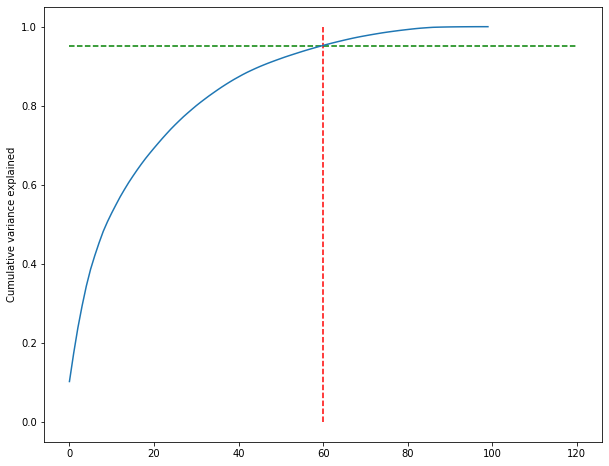

In [66]:
fig = plt.figure(figsize=[10,8])
plt.vlines(x=60, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=120, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

As observed, 60 Principal Components can explain ~ 95% variance in data

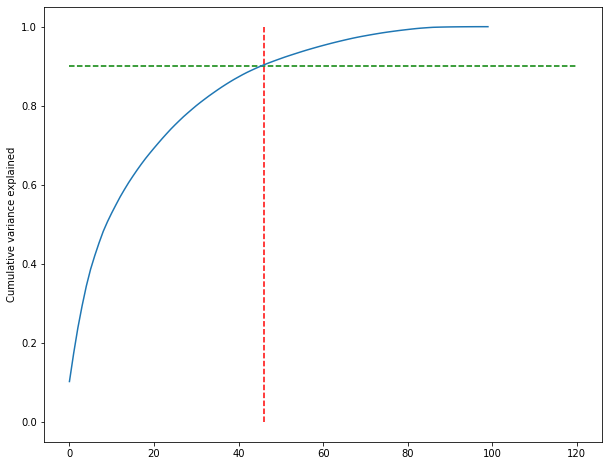

In [67]:
fig = plt.figure(figsize=[10,8])
plt.vlines(x=46, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.9, xmax=120, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

As observed, 46 Principal Components can explain ~ 90% variance in data

In [68]:
# fitting Incremental PCA on training data
pca_final = IncrementalPCA(n_components=46)
df_train_pca = pca_final.fit_transform(X_tr_im)

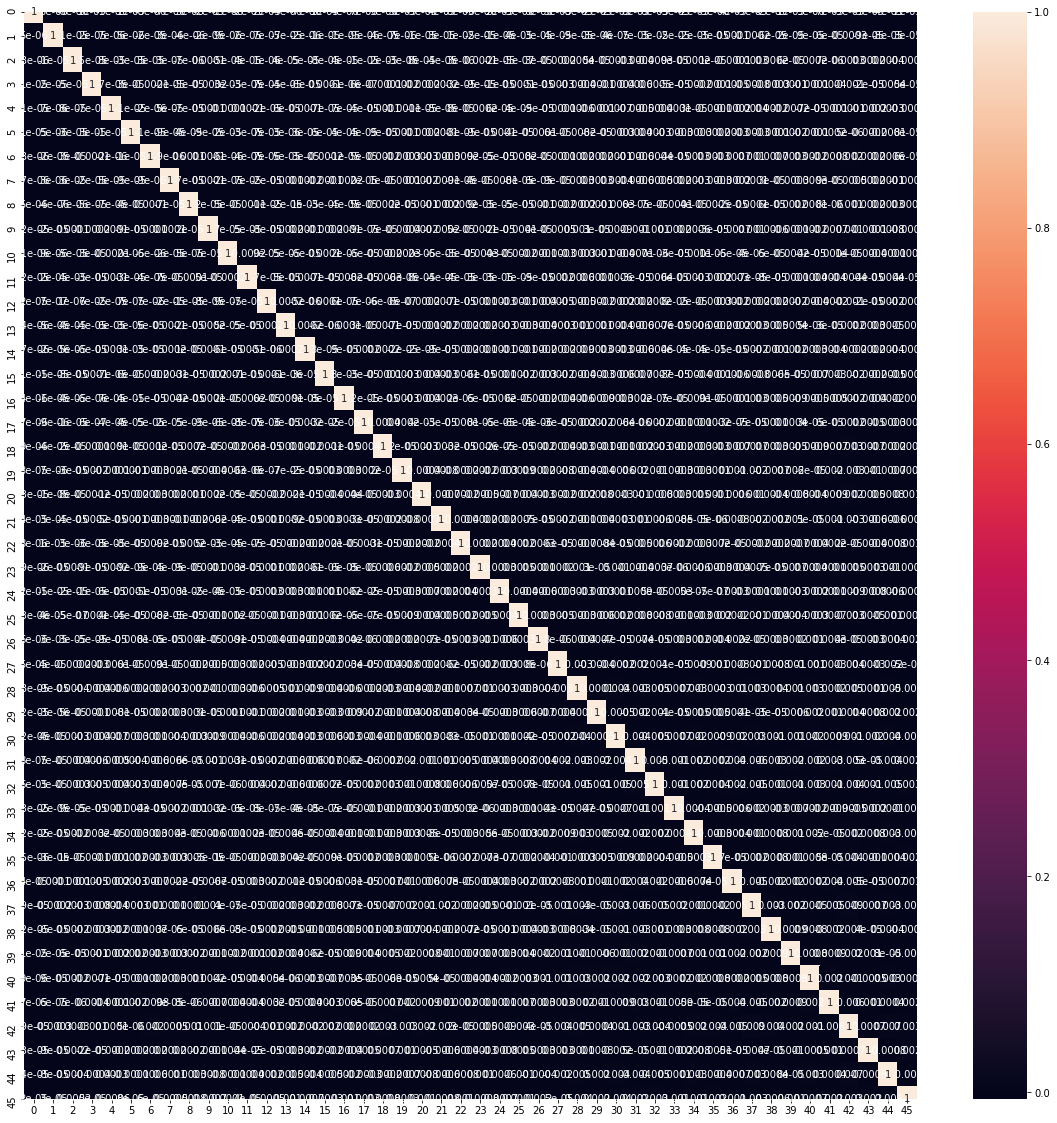

In [69]:
# ploting correlation matrix with 46 principal Components
corrmat = np.corrcoef(df_train_pca.transpose())
plt.figure(figsize=[20,20])
sns.heatmap(corrmat, annot=True,  fmt='.1g')

In [70]:
# transforming test data
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8994, 46)

#### Building Logistic Regression using PCA

In [71]:
# fitting the Logistic Regrssion model
learner_pca = LogisticRegression(class_weight='balanced', random_state=100)
model_pca = learner_pca.fit(df_train_pca, y_tr_im)

In [72]:
# making prediction on training data
train_pred = model_pca.predict(df_train_pca)
pred_probs_train = model_pca.predict_proba(df_train_pca)[:,1]

In [73]:
print("roc_auc_score(Train) with PCA : {:2.4}".format(metrics.roc_auc_score(y_tr_im, pred_probs_train)))
print("Accuracy(Train) with PCA : {:2.4}".format(metrics.accuracy_score(y_tr_im,train_pred)))
print("Recall(Train) with PCA : {:2.4}".format(metrics.recall_score(y_tr_im,train_pred)))
print("Precision(Train) with PCA : {:2.4}".format(metrics.precision_score(y_tr_im,train_pred)))

roc_auc_score(Train) with PCA : 0.9089
Accuracy(Train) with PCA : 0.8435
Recall(Train) with PCA : 0.8573
Precision(Train) with PCA : 0.8342


In [74]:
# creating predecited churn variable from probability using default value of 0.5
cut_off=0.5
y_tr_pred_final= pd.DataFrame({'churn':y_tr_im, 'churn_prob':pred_probs_train})
y_tr_pred_final['predicted'] = y_tr_pred_final.churn_prob.map( lambda x: 1 if x > cut_off else 0)
y_tr_pred_final.head()

,churn,churn_prob,predicted
0,0,0.043438,0
1,0,0.443979,0
2,0,0.009562,0
3,0,0.130948,0
4,0,0.403678,0


ROC Curve

In [75]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

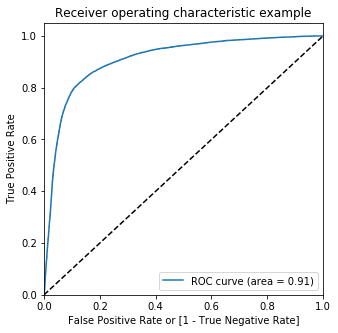

In [76]:
draw_roc(y_tr_pred_final.churn, y_tr_pred_final.churn_prob)

In [77]:
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_tr_pred_final[i]= y_tr_pred_final.churn_prob.map(lambda x: 1 if x > i else 0)
y_tr_pred_final.head()

,churn,churn_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.043438,0,1,0,0,0,0,0,0,0,0,0
1,0,0.443979,0,1,1,1,1,1,0,0,0,0,0
2,0,0.009562,0,1,0,0,0,0,0,0,0,0,0
3,0,0.130948,0,1,1,0,0,0,0,0,0,0,0
4,0,0.403678,0,1,1,1,1,1,0,0,0,0,0


In [78]:
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_tr_pred_final.churn, y_tr_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.699547  0.972308  0.426787
0.2   0.2  0.765941  0.951746  0.580136
0.3   0.3  0.804097  0.924835  0.683358
0.4   0.4  0.828744  0.890688  0.766800
0.5   0.5  0.843475  0.857321  0.829629
0.6   0.6  0.845974  0.811931  0.880017
0.7   0.7  0.831997  0.747020  0.916975
0.8   0.8  0.789209  0.632554  0.945864
0.9   0.9  0.638540  0.298110  0.978970


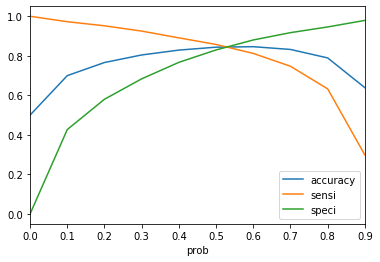

In [79]:
# plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

As Observed above, taking optimal cut-off value as 0.52 slightly higher than 0.5

In [80]:
y_tr_pred_final['final_predicted'] = y_tr_pred_final.churn_prob.map( lambda x: 1 if x > 0.52 else 0)
y_tr_pred_final.final_predicted.value_counts()

1    19357
0    19065
Name: final_predicted, dtype: int64

In [81]:
print("roc_auc_score : {:2.4}".format(metrics.roc_auc_score(y_tr_pred_final.churn, y_tr_pred_final.final_predicted)))
print("Accuracy : {:2.4}".format(metrics.accuracy_score(y_tr_pred_final.churn, y_tr_pred_final.final_predicted)))
print("Recall : {:2.4}".format(metrics.recall_score(y_tr_pred_final.churn, y_tr_pred_final.final_predicted)))
print("Precision : {:2.4}".format(metrics.precision_score(y_tr_pred_final.churn, y_tr_pred_final.final_predicted)))

roc_auc_score : 0.8441
Accuracy : 0.8441
Recall : 0.8479
Precision : 0.8415


Making Prediction on test

In [82]:
# making prediction on test data
y_pred_default = model_pca.predict(df_test_pca)
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]

In [83]:
cut_off = 0.52
y_pred_final= pd.DataFrame({'churn':y_test, 'churn_prob':pred_probs_test})

# Creating new column 'predicted' with 1 if Churn_Prob>0.52 else 0
y_pred_final['predicted'] = y_pred_final.churn_prob.map( lambda x: 1 if x > cut_off else 0)
y_pred_final.head()

,churn,churn_prob,predicted
22880,0,0.000295,0
21814,0,0.055751,0
25755,0,0.087038,0
8765,0,0.346776,0
28867,0,0.748300,1


In [84]:
# check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)

0.8384478541249722

In [85]:
# ROC Score
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.88'

In [86]:
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

array([[6892, 1287],
       [ 166,  649]], dtype=int64)

In [87]:
print("roc_auc_score(Test) with PCA : {:2.4}".format(metrics.roc_auc_score(y_pred_final.churn, y_pred_final.churn_prob)))
print("Accuracy(Test) with PCA : {:2.4}".format(metrics.accuracy_score(y_pred_final.churn,y_pred_final.predicted)))
print("Recall(Test) with PCA : {:2.4}".format(metrics.recall_score(y_pred_final.churn,y_pred_final.predicted)))
print("Precision(Test) with PCA : {:2.4}".format(metrics.precision_score(y_pred_final.churn,y_pred_final.predicted)))

roc_auc_score(Test) with PCA : 0.8834
Accuracy(Test) with PCA : 0.8384
Recall(Test) with PCA : 0.7963
Precision(Test) with PCA : 0.3352


##### Building Logistic Regression with PCA using probabilty cut-off value of 0.52 gives accuracy of 83.8% and Sensitivity/Recall of 79.6%

#### Building Logistic Regression with PCA using L1/L2 Regularization

In [88]:
# Tuning Logistic Regression using L1/L2 regularization

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
grid = GridSearchCV(learner_pca, hyperparameters, cv=5,scoring="recall", verbose=1,n_jobs=-1)

In [89]:
# getting best parameters
grid_result = grid.fit(df_train_pca, y_tr_im)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.1s


Best Score:  0.8558116916673338
Best Params:  {'C': 2.7825594022071245, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.0s finished


In [90]:
# fitting the model
lr_tuned = LogisticRegression(class_weight='balanced',C=2.8 ,penalty="l2")
lr_pca_tuned = lr_tuned.fit(df_train_pca, y_tr_im)

In [93]:
# making prediction on training data
lr_tuned_tr_pred = model_pca.predict(df_train_pca)
lr_tuned_tr_pred_probs= model_pca.predict_proba(df_train_pca)[:,1]
print("roc_auc_score Train : {:2.4}".format(metrics.roc_auc_score(y_tr_im, lr_tuned_tr_pred_probs)))
print("Accuracy Train : {:2.4}".format(metrics.accuracy_score(y_tr_im,lr_tuned_tr_pred)))
print("Recall Train : {:2.4}".format(metrics.recall_score(y_tr_im,lr_tuned_tr_pred)))
print("Precision Train : {:2.4}".format(metrics.precision_score(y_tr_im,lr_tuned_tr_pred)))

roc_auc_score Train : 0.9089
Accuracy Train : 0.8435
Recall Train : 0.8573
Precision Train : 0.8342


In [94]:
# making prediction on test data
lr_tuned_test_pred = model_pca.predict(df_test_pca)
lr_tuned_tst_pred_probs = model_pca.predict_proba(df_test_pca)[:,1]
print("roc_auc_score Test : {:2.4}".format(metrics.roc_auc_score(y_test, lr_tuned_tst_pred_probs)))
print("Accuracy Test : {:2.4}".format(metrics.accuracy_score(y_test,lr_tuned_test_pred)))
print("Recall Test : {:2.4}".format(metrics.recall_score(y_test,lr_tuned_test_pred)))
print("Precision Test : {:2.4}".format(metrics.precision_score(y_test,lr_tuned_test_pred)))

roc_auc_score Test : 0.8834
Accuracy Test : 0.8279
Recall Test : 0.8037
Precision Test : 0.3206


##### Building Logistic Regression with PCA using "L2" regularization and "C=2.8" gives accuracy of 82.8% and Sensitivity/Recall of 80.3%

#### Building Random Forest Model with PCA

In [95]:
## creating Random Forest ensamble and fitting training data 
rfc = RandomForestClassifier(class_weight='balanced', random_state=100)
rfc.fit(df_train_pca, y_tr_im)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [96]:
# Making predictions
predictions = rfc.predict(df_test_pca)

In [97]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8179
           1       0.48      0.56      0.52       815

    accuracy                           0.91      8994
   macro avg       0.72      0.75      0.73      8994
weighted avg       0.91      0.91      0.91      8994



In [98]:
# checking scores of Default Random Forest classifier on Train data
cm_rf = metrics.confusion_matrix( y_test, predictions )
TN = cm_rf[0,0] # true positive 
TP = cm_rf[1,1] # true negatives
FP = cm_rf[0,1] # false positives
FN = cm_rf[1,0] # false negatives

print("ROC : {:2.4}".format(metrics.roc_auc_score(y_test, predictions)))

print("Accuracy : {:2.4}".format(metrics.accuracy_score(y_test, predictions)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))


ROC : 0.7482
Accuracy : 0.9057
Sensitivity:  0.5558
Specificity:  0.9406
False Postive Rate:  0.0594
Positive predictive value:  0.4824
Negative predictive value:  0.9551


###### Random Forest with default parameters provide 90.5% Accuracy and 55.6% Sensitivity/Recall 

Tuning hyper parameters individually, as GridSearch using parameter grid has taken approx 3 hours

Tuning max_depth

In [99]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 4)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True, 
                   scoring="recall")
rf.fit(df_train_pca, y_tr_im)

Wall time: 8min 29s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

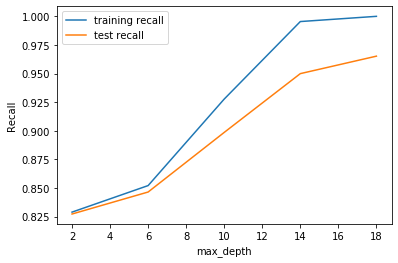

In [100]:
scores = rf.cv_results_

# plotting max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.legend()
plt.show()

18 features show maximum value of Recall on Train & Test data 

Tuning n_estimators

In [101]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(0, 600, 100)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(df_train_pca, y_tr_im)

Wall time: 13min 24s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

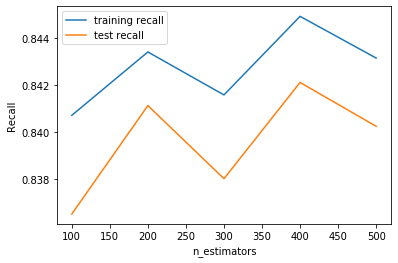

In [102]:
scores = rf.cv_results_

# plotting n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

Recall value for Train data is highest for n_esimators=400 followed by n_esimators=200, but recall for corresponding values of n_estimators on test data are significantly different compared to n_esimators=100 where Recall for both Train & Test data is very similar. 

Tuning max_features

In [103]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(df_train_pca, y_tr_im)

Wall time: 6min 15s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

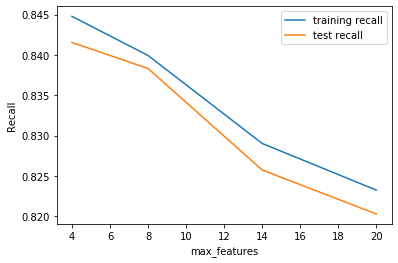

In [104]:
scores = rf.cv_results_

# plotting max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()
plt.show()

 Max_Features = 4 show high value of Recall for Train data but comparatively low for Test data.
 Max_Features = 8 show equally high value for both Test & Train data omparative to other values of Max_Features

Tuning min_samples_leaf

In [105]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(df_train_pca, y_tr_im)

Wall time: 9min 59s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

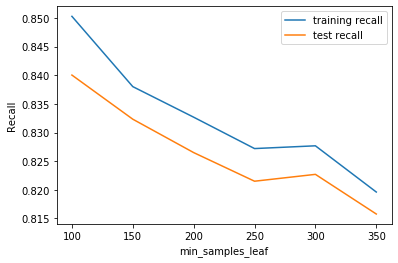

In [106]:
scores = rf.cv_results_

# plotting min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()
plt.show()

 Recall value for min_samples_leaf=100 is highest on Train & Test data compared to other values of min_samples_leaf.

Tuning min_samples_split

In [107]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(1, 200, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(df_train_pca, y_tr_im)

Wall time: 8min 48s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

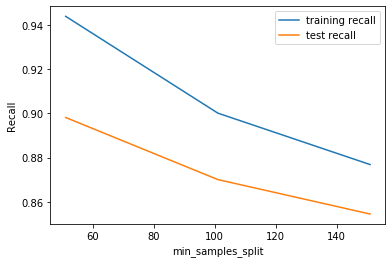

In [108]:
scores = rf.cv_results_

# plotting min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()
plt.show()

 min_samples_split = 51 gives highest values for Recall on both Train & Test data

Building Model with above chosen hyper parameters

In [109]:
# model with the best hyperparameters
rfc_tuned = RandomForestClassifier(bootstrap=True,
                             max_depth=18,
                             min_samples_leaf=100, 
                             min_samples_split=51,
                             max_features=8,
                             n_estimators=100,
                             class_weight='balanced', random_state=100)
# fit the model
rfc_tuned.fit(df_train_pca, y_tr_im)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=18, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=51,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [110]:
# making prediction on test data
y_test_pred_rf = rfc_tuned.predict(df_test_pca)

In [111]:
# checking scores
cm = metrics.confusion_matrix( y_test, y_test_pred_rf )
TN = cm[0,0] # true positive 
TP = cm[1,1] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("ROC : {:2.4}".format(metrics.roc_auc_score(y_test, y_test_pred_rf)))

print("Accuracy : {:2.4}".format(metrics.accuracy_score(y_test, y_test_pred_rf)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))

ROC : 0.8069
Accuracy : 0.8598
Sensitivity:  0.7423
Specificity:  0.8715
False Postive Rate:  0.1285
Positive predictive value:  0.3653
Negative predictive value:  0.9714


##### Random Forest after tuning Hyperparameters provide 86% Accuracy and 74.2% Sensitivity/Recall 

#### Building Gradient Boosting with PCA

In [112]:
# fitting Gradient Boosting model on Train data

GBC = GradientBoostingClassifier(random_state=100)
GBC.fit(df_train_pca,y_tr_im)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=100, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [113]:
# making prediction on test data
y_pred_gb = GBC.predict(df_test_pca)

print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      8179
           1       0.36      0.76      0.49       815

    accuracy                           0.85      8994
   macro avg       0.67      0.81      0.70      8994
weighted avg       0.92      0.85      0.88      8994



In [114]:
# checking scores 
cm = metrics.confusion_matrix( y_test, y_pred_gb )
TN = cm[0,0] # true positive 
TP = cm[1,1] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("ROC: {:2.4}".format(metrics.roc_auc_score(y_test, y_pred_gb)))

print("Accuracy: {:2.4}".format(metrics.accuracy_score(y_test, y_pred_gb)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))

ROC: 0.8137
Accuracy: 0.8541
Sensitivity:  0.7644
Specificity:  0.8631
False Postive Rate:  0.1369
Positive predictive value:  0.3574
Negative predictive value:  0.9735


##### Gradient Boosting with default parameters provide 85.4% Accuracy and 76.4% Sensitivity/Recall

Tuning the model on learning rate and subsample parameters

In [115]:
# parameter grid
param_grid_grad = {"learning_rate": [0.7,0.8,0.9],
                   "subsample": [0.8,0.9]}

In [116]:
%%time
# run grid search
folds = 3

GBC_hyp = GradientBoostingClassifier(random_state=100)

grid_search_GBC = GridSearchCV(GBC_hyp, 
                               cv = folds,
                               param_grid=param_grid_grad, 
                               scoring = 'recall', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_GBC.fit(df_train_pca, y_tr_im)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 17.0min finished


Wall time: 18min 21s


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [117]:
grid_search_GBC.best_params_

{'learning_rate': 0.7, 'subsample': 0.8}

Building the model on optimal hyperparameters

In [118]:
GBC_final = GradientBoostingClassifier(learning_rate=0.7,subsample=0.8, random_state=100)
GBC_final.fit(df_train_pca,y_tr_im)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.7, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=100, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [119]:
# making prediction on test set
y_pred_gb_final = GBC_final.predict(df_test_pca)

print(classification_report(y_test, y_pred_gb_final))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      8179
           1       0.36      0.69      0.48       815

    accuracy                           0.86      8994
   macro avg       0.66      0.78      0.70      8994
weighted avg       0.91      0.86      0.88      8994



In [120]:
# checking scores
cm = metrics.confusion_matrix( y_test, y_pred_gb_final )
TN = cm[0,0] # true positive 
TP = cm[1,1] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("ROC: {:2.4}".format(metrics.roc_auc_score(y_test, y_pred_gb_final)))

print("Accuracy: {:2.4}".format(metrics.accuracy_score(y_test, y_pred_gb_final)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))

ROC: 0.7839
Accuracy: 0.8621
Sensitivity:  0.6883
Specificity:  0.8794
False Postive Rate:  0.1206
Positive predictive value:  0.3626
Negative predictive value:  0.9659


##### Gradient Boosting after tuning Hyperparameters provide 86.2% Accuracy and 68.8% Sensitivity/Recall

#### Building XGBoost with PCA

In [121]:
# fitting model on training data with default hyperparameters
xgb = XGBClassifier(random_state=100)
xgb.fit(df_train_pca, y_tr_im)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=100, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [122]:
# making prediciton on test data
y_pred_xgb = xgb.predict(df_test_pca)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      8179
           1       0.44      0.61      0.51       815

    accuracy                           0.90      8994
   macro avg       0.70      0.77      0.73      8994
weighted avg       0.91      0.90      0.90      8994



In [123]:
# checking scores
cm = metrics.confusion_matrix( y_test, y_pred_xgb )
TN = cm[0,0] # true positive 
TP = cm[1,1] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("ROC: {:2.4}".format(metrics.roc_auc_score(y_test, y_pred_xgb)))

print("Accuracy: {:2.4}".format(metrics.accuracy_score(y_test, y_pred_xgb)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))

ROC: 0.7668
Accuracy: 0.8953
Sensitivity:  0.6098
Specificity:  0.9237
False Postive Rate:  0.0763
Positive predictive value:  0.4434
Negative predictive value:  0.9596


##### XGBoost with default parameters provide 89.5% Accuracy and 60.9% Sensitivity/Recall

In [124]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid_xgb = {"learning_rate": [0.1,0.2,0.5,0.7],
                   "subsample": [0.6,0.7,0.8,0.9]}

# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=300, random_state=100)

# set up GridSearchCV()
xgb_hyp = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid_xgb, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [125]:
%%time
#fit the model
xgb_hyp.fit(df_train_pca, y_tr_im)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 16.3min finished


Wall time: 16min 52s


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimato...
                                     objective='binary:logistic',
                                     random_state=100, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None

In [126]:
xgb_hyp.best_params_

{'learning_rate': 0.7, 'subsample': 0.9}

In [127]:
# chosen hyperparameters
params_xgb_hyp = {'learning_rate': 0.7,'subsample':0.9}

# fit model on training data
model_xgb_final = XGBClassifier(params = params_xgb_hyp,random_state=100)
model_xgb_final.fit(df_train_pca, y_tr_im)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.7, 'subsample': 0.9}, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [128]:
# making prediciton on test data
y_pred_xgb_final = model_xgb_final.predict(df_test_pca)

print(classification_report(y_test, y_pred_xgb_final))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94      8179
           1       0.44      0.61      0.51       815

    accuracy                           0.90      8994
   macro avg       0.70      0.77      0.73      8994
weighted avg       0.91      0.90      0.90      8994



In [129]:
# checking scores
cm = metrics.confusion_matrix( y_test, y_pred_xgb_final )
TN = cm[0,0] # true positive 
TP = cm[1,1] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("ROC: {:2.4}".format(metrics.roc_auc_score(y_test, y_pred_xgb_final)))

print("Accuracy: {:2.4}".format(metrics.accuracy_score(y_test, y_pred_xgb_final)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))


ROC: 0.7668
Accuracy: 0.8953
Sensitivity:  0.6098
Specificity:  0.9237
False Postive Rate:  0.0763
Positive predictive value:  0.4434
Negative predictive value:  0.9596


##### XGBoost after tuning Hyperparameters provide 89.5% Accuracy and 60.9% Sensitivity/Recall

Comparaing Scores of Logistic Regression, Random Forest, Gradient Boosting & XGBoost

In [130]:
print("Logistic Regression : \n")
print("ROC {:2.4}".format(metrics.roc_auc_score(y_pred_final.churn, y_pred_final.churn_prob)))
print("Accuracy {:2.4}".format(metrics.accuracy_score(y_pred_final.churn,y_pred_final.predicted)))
print("Precision {:2.4}".format(metrics.precision_score(y_pred_final.churn,y_pred_final.predicted)))
print("Recall {:2.4}".format(metrics.recall_score(y_pred_final.churn,y_pred_final.predicted)))
print("\n")
print("Logistic Regression with L1/L2 Regularization : \n")
print("ROC {:2.4}".format(metrics.roc_auc_score(y_test, lr_tuned_tst_pred_probs)))
print("Accuracy {:2.4}".format(metrics.accuracy_score(y_test,lr_tuned_test_pred)))
print("Precision {:2.4}".format(metrics.precision_score(y_test,lr_tuned_test_pred)))
print("Recall {:2.4}".format(metrics.recall_score(y_test,lr_tuned_test_pred)))
print("\n")
print("Random Forest : \n")
print("ROC {:2.4}".format(metrics.roc_auc_score(y_test, predictions)))
print("Accuracy {:2.4}".format(metrics.accuracy_score(y_test, predictions)))
print("Precision {:2.4}".format(metrics.precision_score(y_test, predictions)))
print("Recall {:2.4}".format(metrics.recall_score(y_test, predictions)))
print("\n")
print("Gradient Boosting : \n")
print("ROC {:2.4}".format(metrics.roc_auc_score(y_test, y_pred_gb_final)))
print("Accuracy {:2.4}".format(metrics.accuracy_score(y_test, y_pred_gb_final)))
print("Precision {:2.4}".format(metrics.precision_score(y_test, y_pred_gb_final)))
print("Recall {:2.4}".format(metrics.recall_score(y_test, y_pred_gb_final)))
print("\n")
print("XGBoost : \n")
print("ROC {:2.4}".format(metrics.roc_auc_score(y_test, y_pred_xgb_final)))
print("Accuracy {:2.4}".format(metrics.accuracy_score(y_test, y_pred_xgb_final)))
print("Precision {:2.4}".format(metrics.precision_score(y_test, y_pred_xgb_final)))
print("Recall {:2.4}".format(metrics.recall_score(y_test, y_pred_xgb_final)))

Logistic Regression : 

ROC 0.8834
Accuracy 0.8384
Precision 0.3352
Recall 0.7963


Logistic Regression with L1/L2 Regularization : 

ROC 0.8834
Accuracy 0.8279
Precision 0.3206
Recall 0.8037


Random Forest : 

ROC 0.7482
Accuracy 0.9057
Precision 0.4824
Recall 0.5558


Gradient Boosting : 

ROC 0.7839
Accuracy 0.8621
Precision 0.3626
Recall 0.6883


XGBoost : 

ROC 0.7668
Accuracy 0.8953
Precision 0.4434
Recall 0.6098


Comparing the ROC, Accuracy and Recall/Sensitivity metrics among the 5 models we've built. We are looking for model which can provide the best Recall/Sensitivity score as our objective here is to correctly predict Churn Customers(or True Positves). Logistic Regression with PCA using L2 regularization and C=2.8 provides the best results.

Accuracy : 82.8%

Sensitivity : 80.4%

### Building Random Forest Model for interpretation of important churn indicators

#### Building Random Forest wihout PCA

In [131]:
## creating Random Forest ensamble and fitting training data 
rfc = RandomForestClassifier(class_weight='balanced', random_state=100)
rfc.fit(X_tr_im, y_tr_im)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [132]:
# Making predictions
y_test_pred_rf = rfc.predict(X_test)

In [133]:
# Let's check the report of our default model
print(classification_report(y_test,y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      8179
           1       0.58      0.62      0.60       815

    accuracy                           0.92      8994
   macro avg       0.77      0.79      0.78      8994
weighted avg       0.93      0.92      0.93      8994



In [134]:
print("RF without PCA(Default): \n")
# checking scores
cm = metrics.confusion_matrix( y_test, y_test_pred_rf )
TN = cm[0,0] # true positive 
TP = cm[1,1] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("ROC: {:2.4}".format(metrics.roc_auc_score(y_test, y_test_pred_rf)))

print("Accuracy: {:2.4}".format(metrics.accuracy_score(y_test, y_test_pred_rf)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))

RF without PCA(Default): 

ROC: 0.7885
Accuracy: 0.9247
Sensitivity:  0.6221
Specificity:  0.9549
False Postive Rate:  0.0451
Positive predictive value:  0.5788
Negative predictive value:  0.9621


##### Random Forest with default parameters provide 92.5% Accuracy and 62.2% Sensitivity/Recall

Tuning Hyperparameters

Tuning max_depth

In [135]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 20, 5)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True, 
                   scoring="recall")
rf.fit(X_tr_im, y_tr_im)

Wall time: 5min 50s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [136]:
scores = rf.cv_results_

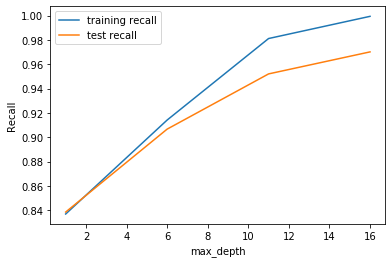

In [137]:
# plotting max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.legend()
plt.show()

max_depth = 16 provides highest values of Recall on both Train & Test data.

Tuning n_estimators

In [138]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 200)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(X_tr_im, y_tr_im)

Wall time: 19min 14s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

In [139]:
scores = rf.cv_results_

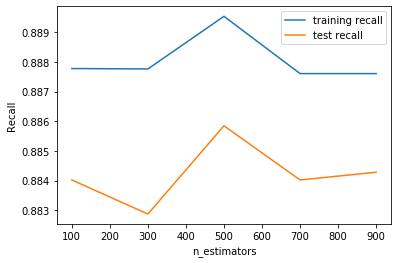

In [140]:
# plotting n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.legend()
plt.show()

Though n_estimators = 300 provides highest value of Recall on train data, its comparatively low on test data. While for n_estimators=500 provides equally similar values of Recall for Train & Test data.

Tuning max_features

In [141]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [5, 10, 15, 20]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(X_tr_im, y_tr_im)

Wall time: 4min 4s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_s

In [142]:
scores = rf.cv_results_

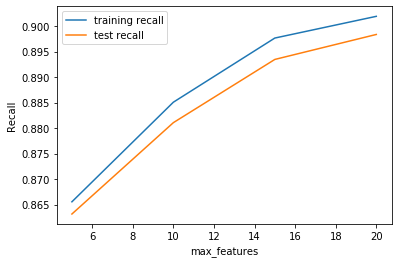

In [143]:
# plotting max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()
plt.show()

max_features = 20 provides highest & Similar values of Recall on Train & Test data

Tuning min_samples_leaf

In [144]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 200, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(X_tr_im, y_tr_im)

Wall time: 5min 42s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [145]:
scores = rf.cv_results_

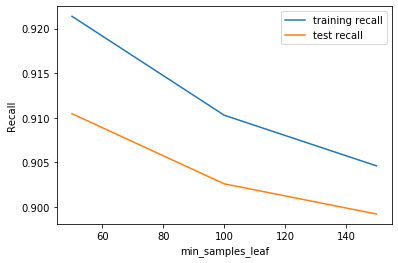

In [146]:
# plotting min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()
plt.show()

min_samples_leaf = 50 provides highest values of Recall on Train & Test data

Tuning min_samples_split

In [147]:
%%time
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(50, 250, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="recall")
rf.fit(X_tr_im, y_tr_im)

Wall time: 10min 59s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [148]:
scores = rf.cv_results_

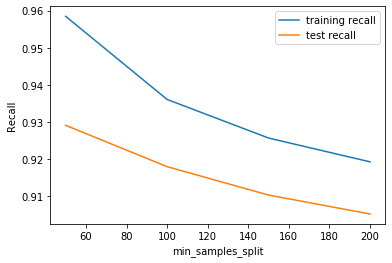

In [149]:
# plotting min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()
plt.show()

min_samples_split=50 provides highest values of Recall on Train & Test data

In [150]:
# model with the best hyperparameters
rfc_final= RandomForestClassifier(bootstrap=True,class_weight='balanced',random_state=100,
                             max_depth=10,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=16,
                             n_estimators=500)

In [151]:
# fit
rfc_final.fit(X_tr_im, y_tr_im)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features=16,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [152]:
# predict
y_test_pred_rf = rfc_final.predict(X_test)

In [153]:
print("RF without PCA(Default): \n")
# checking scores
cm = metrics.confusion_matrix( y_test, y_test_pred_rf )
TN = cm[0,0] # true positive 
TP = cm[1,1] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

print("ROC: {:2.4}".format(metrics.roc_auc_score(y_test, y_test_pred_rf)))

print("Accuracy: {:2.4}".format(metrics.accuracy_score(y_test, y_test_pred_rf)))

print('Sensitivity: ',round(TP / float(TP+FN),4))

print('Specificity: ',round(TN / float(TN+FP),4))

print('False Postive Rate: ',round(FP/ float(TN+FP),4))

print('Positive predictive value: ',round(TP / float(TP+FP),4))

print('Negative predictive value: ',round(TN / float(TN+ FN),4))

RF without PCA(Default): 

ROC: 0.8308
Accuracy: 0.8933
Sensitivity:  0.7546
Specificity:  0.9071
False Postive Rate:  0.0929
Positive predictive value:  0.4473
Negative predictive value:  0.9737


##### Random Forest after Hyperparameter tuning provide 89.3% Accuracy and 75.5% Sensitivity/Recall

In [154]:
#Important features
from collections import OrderedDict
feature_names=list(X.columns.values)
important_features_dict = {}
for name, importance in zip(feature_names, rfc_final.feature_importances_):
    important_features_dict[name]=importance

#Sorting Dictionary in descending order of the importance 
d_descending = OrderedDict(sorted(important_features_dict.items(), 
                                  key=lambda kv: kv[1], reverse=True))

In [155]:
#Variable Importance top 15 features
dic= dict(d_descending)

from itertools import islice

def take(n, iterable):
    return list(islice(iterable, n))

n=15
n_features = take(n, dic.items())

In [156]:
n_features

[('roam_ic_mou_8', 0.17747744121989256),
 ('roam_og_mou_8', 0.16876299472077128),
 ('changed_arpu', 0.08189162563561257),
 ('max_rech_amt_8', 0.07675607014758401),
 ('changed_total_rech_amt', 0.06797178643324674),
 ('last_day_rch_amt_8', 0.05609357432597699),
 ('loc_og_t2m_mou_8', 0.043428933454364896),
 ('loc_ic_t2m_mou_8', 0.0366400886588379),
 ('changed_total_og_mou', 0.032957368584434744),
 ('changed_total_ic_mou', 0.026722056825706424),
 ('total_rech_num_8', 0.02273304332890833),
 ('offnet_mou_8', 0.018397122592364888),
 ('loc_og_t2t_mou_8', 0.015599353236176134),
 ('changed_std_og_mou', 0.013738340423737058),
 ('loc_ic_t2t_mou_8', 0.012684813091343653)]

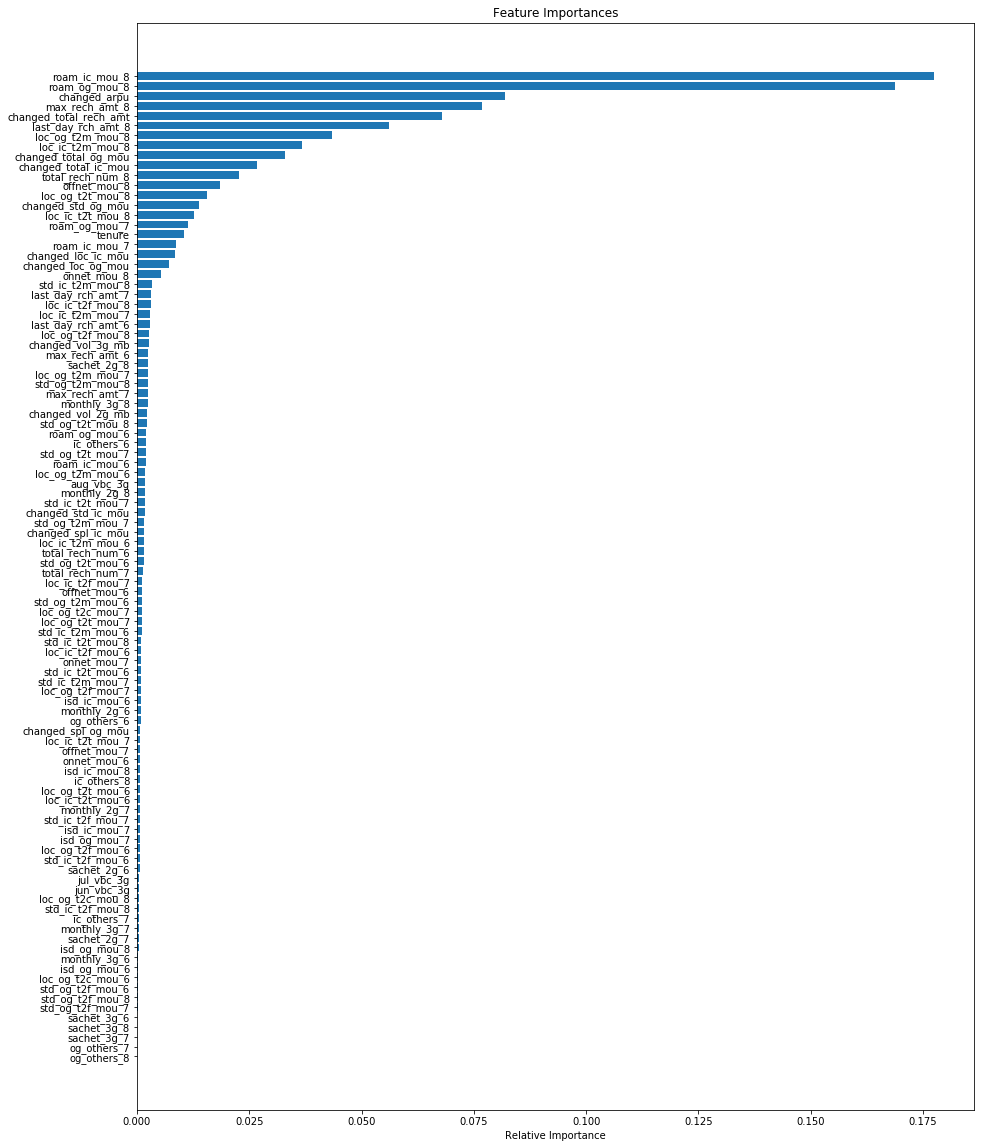

In [157]:
features = list(X.columns.values)
importances = rfc_final.feature_importances_
indices = np.argsort(importances)
fig = plt.figure(figsize=[15,20])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Top 10 Important Churn Indicators

roam_ic_mou_8 - (Incoming Minutes of Usage in Roaming - Action Phase)

roam_og_mou_8 - (Outgoing Minutes of Usage in Roaming - Action Phase)

changed_arpu - (Change in Average revenue from Good phase to Action phase)

max_rech_amt_8 - (Maximum recharge amount in Action phase)

changed_total_rech_amt - (Change in total recharge amount from Good phase to Action phase)

last_day_rch_amt_8 - (Last Day of Recharge amount in action phase)

loc_og_t2m_mou_8 - (Local outgoing usage Operator T to other operator mobile in Action phase)

loc_ic_t2m_mou_8 - (Local incoming usage Operator T to other operator mobile in Action phase)

changed_total_og_mou - (Change in total outgoing usage from Good phase to Action phase) 

changed_total_ic_mou - (Change in total incoming usage from Good phase to Action phase) 

offnet_mou_8 - (All kind of calls outside the operator T network in Action phase)

changed_std_og_mou - (Change in STD outgoing usage from Good phase to Action phase)

### Recommendations

1. We could see roam_ic_mou is one of the most important feature obtained . Company can probably do a market reserach and come up with newer roaming packs in competition to other operators. This might help in retaining the customers who are leaving because the roaming pack is not good.

2. Another important feature which stand out is loc_og_t2m_mou/ loc_ic_t2m_mou. From the graph below we can see there is a drop in usage of minutes in both incoming and outgoing to other mobile operators. Company can look for introducing better plans for calls on other networks, which might help retain the customers.

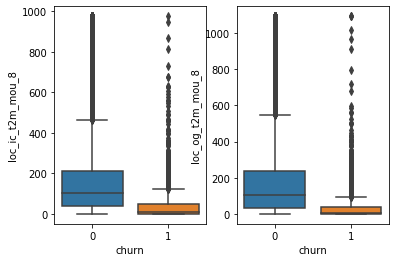

In [158]:
fig, axs = plt.subplots(ncols=2)
sns.boxplot(telecom_df['churn'], telecom_df['loc_ic_t2m_mou_8'],ax=axs[0])
sns.boxplot(telecom_df['churn'], telecom_df['loc_og_t2m_mou_8'],ax=axs[1])

3. From the graph below we see a significant drop in outgoing STD usage, and changed_std_og_mou turns out be a important feature. Company can probably look for introducing better STD packs to retain the customers.

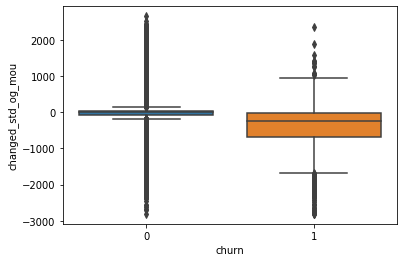

In [159]:
sns.boxplot(telecom_df['churn'], telecom_df['changed_std_og_mou'])

4.offnet_mou also seems to be a strong churning indicator and we see a drop in offnet call minute in action phase for churned customers. Company can inroduce better off network plan for all kind of calls to help retain the customers. 

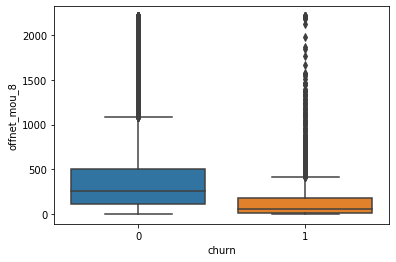

In [160]:
sns.boxplot(telecom_df['churn'], telecom_df['offnet_mou_8'])

To implement above mentioned startegy recommendations. Company can go for a survey among its existing customers to better understand their uses and expectation from the operators and come up with a plan to introduce better plans which suits customer needs. It will help retain the cutomers for the company.